### carico dipendenze

In [1]:
import argparse
import logging
import os
import sys
from importlib import reload
from itertools import product
from pathlib import Path

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import yaml
from geopandas import points_from_xy
from matplotlib.colors import LogNorm, PowerNorm
from numpy.lib.stride_tricks import as_strided
from rasterio import CRS
from rasterio.transform import Affine, AffineTransformer
from scipy.signal import convolve2d
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle
from skimage.registration import (optical_flow_ilk, optical_flow_tvl1,
                                  phase_cross_correlation)
from skimage.util import img_as_float, img_as_float32, img_as_float64
from tqdm import tqdm

try:
    import ot

except ModuleNotFoundError:
    path = Path(os.environ['USERPROFILE']) / "paracelso_wp32"
    assert path.exists()
    sys.path.append(str(path))

import ot
from ot import utils as otu
from ot.algoritmi import (OpenCVOpticalFlow, SkiOpticalFlowILK,
                          SkiOpticalFlowTVL1)
from ot.image_processing import common as img_common
from ot.image_processing import dispatcher
from ot.image_processing.common import to_single_band_uint8
from ot.interfaces import Image
from ot.metodi import get_method
from ot.utils import rasterio_read

In [2]:
def get_corvara_dataset():
    path = "W:/SoLoMon/Siti/Corvara/DEM/" +\
        "LiDAR_HELICA_2019_2022/Elaborazioni_UNIMORE" +\
        "/IRIS_corvara_2022/Elaborazione_HSD_NCC"
    return dict(enumerate(Path(path).rglob("*.tif*")))


def get_output_dataset():
    path = "../output"
    return dict(enumerate(Path(path).rglob("*.tif*")))


def print_summary_statistics(array):
    print(f"\n{'<'*15}| STATS |{'>'*15}")
    print(f"              Mean: {np.mean(array): .3g}")
    print(f"            Median: {np.median(array): .3g}")
    print(f"Standard Deviation: {np.std(array): .3g}")
    print(f"           Minimum: {np.min(array): .3g}")
    print(f"           Maximum: {np.max(array): .3g}")
    print(f"   25th Percentile: {np.percentile(array, 25): .3g}")
    print(f"   75th Percentile: {np.percentile(array, 75): .3g}")


def get_pictures_files(pattern: str = "*.jp*"):
    root = os.environ['USERPROFILE']
    pictures_path = os.path.join(root, "Pictures")
    return dict(enumerate(Path(pictures_path).rglob(pattern)))


def get_png_images():
    return dict(enumerate(Path("C:\\Users\\vcritell\\Pictures\\").glob("*.png")))


def normalize_default(array):
    return cv2.normalize(array, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


def infer_nodata_mask(array: np.ndarray, use_max: bool = False) -> np.ndarray:
    vmin, vmax = np.percentile(array, [0.001, 99.999])

    if use_max:
        return array >= vmax
    else:
        return array <= vmin


def homogenize_nan(array, nodata, overwrite_nodata=None):
    array = array.copy()
    mask = (array == nodata).any(axis=2)
    new_nan = overwrite_nodata or nodata

    for i in range(array.shape[-1]):
        array[:, :, i][mask] = new_nan

    return array


def apply_mask(array, mask):
    return np.ma.masked_array(array, mask)

In [3]:
def _kij_to_ijk(arr: np.ndarray) -> np.ndarray:
    return np.transpose(arr, (1, 2, 0))


def _convert_to_band_last(func, *args, **kwargs):
    def inner(*args, **kwargs):
        result = func(*args, **kwargs)
        return _kij_to_ijk(result)
    return inner


def _gen_array_uint8():
    return (np.random.normal(size=(500, 500)) * 1250 / 255).astype(np.uint8)


def _gen_array_float32():
    return (np.random.normal(size=(500, 500)) * 1250 / 255).astype(np.uint8)


@_convert_to_band_last
def _gen_3darray_uint8():
    return (np.random.normal(size=(3, 500, 500)) * 1250 / 255).astype(np.uint8)


@_convert_to_band_last
def _gen_3darray_float32():
    return np.random.normal(size=(3, 500, 500)) * np.random.randint(10, 1000)

@_convert_to_band_last
def _gen_3darray_float32_nodata():
    arr = np.random.normal(size=(3, 20, 20)) * 125.23
    arr = np.sqrt(arr**2)
    arr[:, 0, :] = np.nan
    arr[:, -1, :] = np.nan
    arr[:, :, 0] = np.nan
    arr[:, :, -1] = np.nan

    return arr


@_convert_to_band_last
def _gen_3darray_uint8_nodata():
    arr = (np.random.normal(size=(3, 20, 20)) * 1250 / 255).astype(np.uint32)
    arr = np.sqrt(arr**2)
    arr[:, 0, :] = np.nan
    arr[:, -1, :] = np.nan
    arr[:, :, 0] = np.nan
    arr[:, :, -1] = np.nan

    return arr

### Testing

In [ ]:
def load_images_dummy():
    from ot.main import load_images
    
    a = get_corvara_dataset()[10]
    b = get_corvara_dataset()[11]

    a = str(get_pictures_files(pattern='*png')[0])
    b = str(get_pictures_files(pattern='*png')[1])

    return load_images(a, b)


def main(method, *immagini):

    algorithm = get_method(method).from_YAML(f"../ot/{method}.yaml")
    
    img_ar1, img_ar2 = load_images_dummy()

    prep_imgs = list()
    for img in [img_ar1, img_ar2]:
        _img = dispatcher.dispatch_process(f"{algorithm.library}_"+'clahe', array=img)
        prep_imgs.append(_img)


    return algorithm(*prep_imgs)

In [5]:
np.random.seed(123456789)

logger = logging.getLogger(ot.__name__)

methods = ["SKIOFTVL1", "SKIOFILK", "OPENCVOF", "SKIPCCV"]

flows = dict()
for method in methods:
    flows[method] = main(method)

2025.03.12-16:43:37 [ot.load_images - 141][INFO] - REFERENCE: Screenshot 2025-03-05 113007.png
2025.03.12-16:43:37 [ot.load_images - 142][INFO] - TARGET: Screenshot 2025-03-10 113057.png
2025.03.12-16:43:37 [ot.utils.rasterio_read - 101][INFO] - Caricamento dataset raster
2025.03.12-16:43:37 [ot.utils.rasterio_read - 102][DEBUG] - Caricamento C:\Users\localadmin\Pictures\Screenshots\Screenshot 2025-03-05 113007.png con rasterio.
c:\Users\localadmin\paracelso_wp32\wp32\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
2025.03.12-16:43:37 [ot.utils.rasterio_read - 101][INFO] - Caricamento dataset raster
2025.03.12-16:43:37 [ot.utils.rasterio_read - 102][DEBUG] - Caricamento C:\Users\localadmin\Pictures\Screenshots\Screenshot 2025-03-10 113057.png con rasterio.
2025.03.12-16:43:37 [ot.load_images - 163][WARNING] - Ne

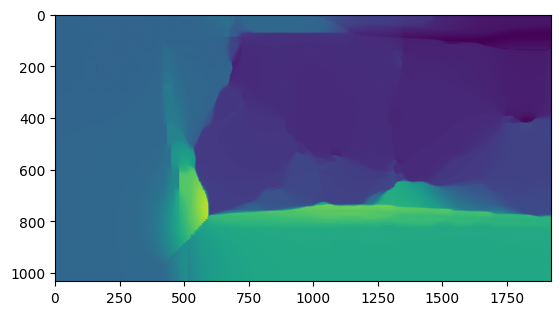

In [6]:
plt.imshow(flows['SKIOFTVL1'].image)

c:\Users\localadmin\paracelso_wp32\wp32\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


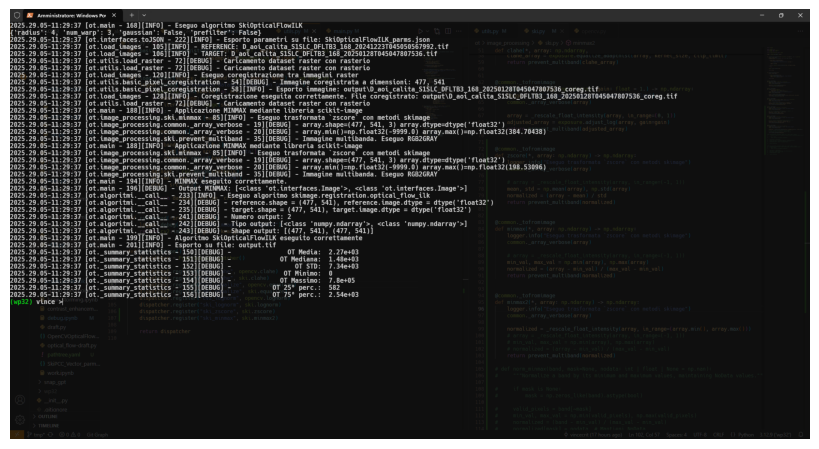

In [8]:
a = str(get_pictures_files(pattern='*png')[0])

with rasterio.open(a, "r") as ds:
    array = ds.read()

def np_layout_to_cv2(array):
    alpha_band = None

    if array.ndim < 3:
        pass

    else:
        if array.shape[0] > 3:
            alpha_band = array[0, :, :].copy()
            array = array[:3, :, :]

        elif array.shape[0] == 2:
            b1, b2 = array
            array = np.stack([b1, b2, b2/b1])

    if not img_common._is_cv8u(array):
        array *= 1/255
        array = array.astype(np.uint8)

    stacked = np.stack([*array], axis=-1)
    return cv2.cvtColor(stacked, cv2.COLOR_RGB2BGR)


fig, ax = plt.subplots(figsize=(10.32, 19.20))
ax.axis('off')
plt.imshow(np_layout_to_cv2(array))